In [1]:
# Importing all libraries.
from pylab import *
from netCDF4 import Dataset
%matplotlib inline
import os
import cmocean as cm
from trackeddy.tracking import *
from trackeddy.datastruct import *
from trackeddy.geometryfunc import *
from trackeddy.init import *
from trackeddy.physics import *
from trackeddy.plotfunc import *

import xarray as xr

In [2]:
sla_file='/g/data3/hh5/tmp/akm157/mom01v5_kds75/output306/rregionsouthern_ocean_daily_eta_t.nc'

mdt_file='/home/156/jm5970/github/trackeddy/data.input/meanssh_10yrs_AEXP.nc'

In [3]:
dataset_mdt = Dataset(mdt_file,'r')
lat_mdt         = dataset_mdt.variables['Latitude'][:]
lon_mdt         = dataset_mdt.variables['Longitude'][:]
mdt             = dataset_mdt.variables['SSH_mean'][:,:,:]

In [4]:
dataset_adt = Dataset(sla_file,'r')
eta         = dataset_adt.variables['eta_t'][:,:,:]
sla         = eta - mdt/100
time        = dataset_adt.variables['time'][:]    
lat     = dataset_adt.variables['yt_ocean_sub01'][:]
lon     = dataset_adt.variables['xt_ocean_sub01'][:]

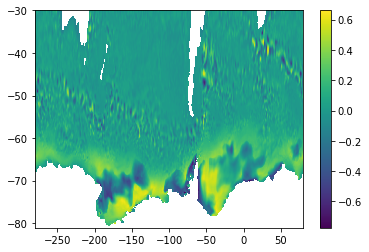

In [5]:
pcolormesh(lon,lat,sla[0,:,:])
colorbar()

In [6]:
def circle(x,y,r):
    theta = linspace(0,2*np.pi,100)
    x_0 = r * cos(theta) +x
    y_0 = r * sin(theta) +y
    return x_0,y_0
    
def maskoutcontour(x_0,y_0,r,lon,lat,field,fillval=False):
    maskfield=np.zeros(np.shape(field))
    #print(shape(field))
    xin=find(lon,x_0-r)
    xfn=find(lon,x_0+r)
    yin=find(lat,y_0-r)
    yfn=find(lat,y_0+r)
    for ii in range(xin,xfn):
        for jj in range(yin,yfn):
            dist = np.sqrt((x_0 - lon[ii]) ** 2 + (y_0 - lat[jj]) ** 2)
            if dist <= r and shape(maskfield)[0]==len(lat):
                maskfield[jj,ii]=True
            elif dist <= r and shape(maskfield)[0]==len(lon):
                maskfield[ii,jj]=True
    maskfield[maskfield==0]=False
    msla = np.ma.masked_where(maskfield==False, field)
    pcolormesh(msla)
    show()
    return msla


def maskoutcontour(x_0,y_0,r,lon,lat,field,fillval=False):
    maskfield=np.zeros(np.shape(field))
    #print(shape(field))
    for ii in range(0,len(lon)):
        for jj in range(0,len(lat)):
            dist = np.sqrt((x_0 - lon[ii]) ** 2 + (y_0 - lat[jj]) ** 2)
            if dist <= r and shape(maskfield)[0]==len(lat):
                maskfield[jj,ii]=True
            elif dist <= r and shape(maskfield)[0]==len(lon):
                maskfield[ii,jj]=True
    maskfield[maskfield==0]=False
    if fillval==False:
        msla = np.ma.masked_where(maskfield==fillval, field)
        #pcolormesh(field)
        #show()
    else:
        field[maskfield==False]=fillval
        msla=field
    #pcolormesh(maskfield)
    #show()
    return msla

In [7]:

lat_cir=-50
lon_cir=-100

x_circle,y_circle=circle(lon_cir,lat_cir,3)

mfield=maskoutcontour(lon_cir,lat_cir,3,lon,lat,sla[0,:,:])
print(shape(mfield))

(931, 3600)


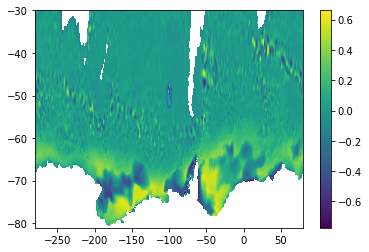

In [8]:
pcolormesh(lon,lat,sla[0,:,:])
colorbar()
pcolormesh(lon,lat,mfield)
plot(x_circle,y_circle)


In [9]:
radius=3
mask={}
ii=1000
blank=ones(shape(sla))
xin=find(lon,lon[ii]-radius)
xfn=find(lon,lon[ii]+radius)
for jj in range(0,len(lat)):
    yin=find(lat,lat[jj]-radius)
    yfn=find(lat,lat[jj]+radius)
    mask[str(lat[jj])]= maskoutcontour(lon[ii],lat[jj],radius,lon[xin:xfn],lat[yin:yfn],blank[0,yin:yfn,xin:xfn])
    #print(shape(mask[str(lat[jj])]),lat[jj])

In [10]:
sla[sla==sla[0,0,0]]=np.nan

In [11]:
import time
meanfiltered=zeros(shape(sla))
for tt in range(0,1):
    for ii in range(0,len(lon)):
        print(ii)
        init=time.clock()
        for jj in range(0,len(lat)):
            xin=find(lon,lon[ii]-radius)
            xfn=find(lon,lon[ii]+radius)
            yin=find(lat,lat[jj]-radius)
            yfn=find(lat,lat[jj]+radius)
            #print(ii<=find(lon,lon[0]+radius))
            if ii < find(lon,lon[0]+radius):
                xinf=find(lon,lon[ii]-radius+360)-len(lon)
                data=hstack((sla[tt,yin:yfn,xinf:],sla[tt,yin:yfn,:xfn]))
            elif ii>find(lon,lon[len(lon)-1]-radius):
                xinf=find(lon,lon[ii]+radius-360)
            #    print(xinf)
                data=hstack((sla[tt,yin:yfn,xin:],sla[tt,yin:yfn,:xinf]))
            #    print(shape(data))
            else:
                data=sla[tt,yin:yfn,xin:xfn]
            #print(lat[jj],shape(mask[str(lat[jj])]))
            if np.ma.is_masked(sla[tt,jj,ii])!=True or abs(sla[tt,jj,ii]) > 1000 :
                #print(np.shape(sla[tt,yin:yfn,xin:xfn]),shape(mask[str(lat[jj])]))
                #pcolormesh(mask[str(lat[jj])])
                #show()
                #pcolormesh(mask[str(lat[jj])])
                #colorbar()
                #show()
                mfield=data*mask[str(lat[jj])]
                #pcolormesh(mfield)
                #colorbar()
                #show()
                #mfield=maskoutcontour(lon[ii],lat[jj],3,lon[xin:xfn],lat[yin:yfn],sla[tt,yin:yfn,xin:xfn])
                meanfiltered[tt,jj,ii]=nanmean(mfield)
            else:
                meanfiltered[tt,jj,ii]=np.nan
                
        print('Time Ellapsed:',time.clock()-init)

0
Time Ellapsed: 0.7700000000000102
1
Time Ellapsed: 0.8199999999999932
2
Time Ellapsed: 0.75
3
Time Ellapsed: 0.7999999999999972
4
Time Ellapsed: 0.7800000000000011
5
Time Ellapsed: 0.7600000000000051
6
Time Ellapsed: 0.8199999999999932
7
Time Ellapsed: 0.75
8
Time Ellapsed: 0.75
9
Time Ellapsed: 0.8200000000000074
10
Time Ellapsed: 0.75
11
Time Ellapsed: 0.769999999999996
12
Time Ellapsed: 0.7700000000000102
13
Time Ellapsed: 0.8199999999999932
14
Time Ellapsed: 0.75
15
Time Ellapsed: 0.75
16
Time Ellapsed: 0.75
17
Time Ellapsed: 0.7599999999999909
18
Time Ellapsed: 0.7400000000000091
19
Time Ellapsed: 0.789999999999992
20
Time Ellapsed: 0.75
21
Time Ellapsed: 0.75
22
Time Ellapsed: 0.7600000000000051
23
Time Ellapsed: 0.7599999999999909
24
Time Ellapsed: 0.730000000000004
25
Time Ellapsed: 0.75
26
Time Ellapsed: 0.8200000000000074
27
Time Ellapsed: 0.7599999999999909
28
Time Ellapsed: 0.7400000000000091
29
Time Ellapsed: 0.7399999999999949
30
Time Ellapsed: 0.7099999999999937
31
Tim

Time Ellapsed: 0.75
226
Time Ellapsed: 0.660000000000025
227
Time Ellapsed: 0.6399999999999864
228
Time Ellapsed: 0.7300000000000182
229
Time Ellapsed: 0.6800000000000068
230
Time Ellapsed: 0.7899999999999636
231
Time Ellapsed: 0.6700000000000159
232
Time Ellapsed: 0.6499999999999773
233
Time Ellapsed: 0.7100000000000364
234
Time Ellapsed: 0.6999999999999886
235
Time Ellapsed: 0.7099999999999795
236
Time Ellapsed: 0.7100000000000364
237
Time Ellapsed: 0.6800000000000068
238
Time Ellapsed: 0.6899999999999977
239
Time Ellapsed: 0.67999999999995
240
Time Ellapsed: 0.6700000000000159
241
Time Ellapsed: 0.7100000000000364
242
Time Ellapsed: 0.6599999999999682
243
Time Ellapsed: 0.7200000000000273
244
Time Ellapsed: 0.7199999999999704
245
Time Ellapsed: 0.6999999999999886
246
Time Ellapsed: 0.6700000000000159
247
Time Ellapsed: 0.7200000000000273
248
Time Ellapsed: 0.7099999999999795
249
Time Ellapsed: 0.6700000000000159
250
Time Ellapsed: 0.6699999999999591
251
Time Ellapsed: 0.670000000000

Time Ellapsed: 0.6599999999999682
445
Time Ellapsed: 0.660000000000025
446
Time Ellapsed: 0.7400000000000091
447
Time Ellapsed: 0.6599999999999682
448
Time Ellapsed: 0.7000000000000455
449
Time Ellapsed: 0.67999999999995
450
Time Ellapsed: 0.660000000000025
451
Time Ellapsed: 0.7300000000000182
452
Time Ellapsed: 0.6700000000000159
453
Time Ellapsed: 0.6699999999999591
454
Time Ellapsed: 0.6700000000000159
455
Time Ellapsed: 0.7400000000000091
456
Time Ellapsed: 0.7099999999999795
457
Time Ellapsed: 0.6700000000000159
458
Time Ellapsed: 0.7300000000000182
459
Time Ellapsed: 0.6699999999999591
460
Time Ellapsed: 0.7300000000000182
461
Time Ellapsed: 0.660000000000025
462
Time Ellapsed: 0.7299999999999613
463
Time Ellapsed: 0.6700000000000159
464
Time Ellapsed: 0.7200000000000273
465
Time Ellapsed: 0.6699999999999591
466
Time Ellapsed: 0.6700000000000159
467
Time Ellapsed: 0.6700000000000159
468
Time Ellapsed: 0.6699999999999591
469
Time Ellapsed: 0.6899999999999977
470
Time Ellapsed: 0.

Time Ellapsed: 0.67999999999995
664
Time Ellapsed: 0.6700000000000728
665
Time Ellapsed: 0.6699999999999591
666
Time Ellapsed: 0.6599999999999682
667
Time Ellapsed: 0.6900000000000546
668
Time Ellapsed: 0.6699999999999591
669
Time Ellapsed: 0.75
670
Time Ellapsed: 0.6699999999999591
671
Time Ellapsed: 0.6900000000000546
672
Time Ellapsed: 0.6899999999999409
673
Time Ellapsed: 0.7400000000000091
674
Time Ellapsed: 0.7100000000000364
675
Time Ellapsed: 0.6699999999999591
676
Time Ellapsed: 0.7299999999999045
677
Time Ellapsed: 0.6600000000000819
678
Time Ellapsed: 0.6699999999999591
679
Time Ellapsed: 0.67999999999995
680
Time Ellapsed: 0.7000000000000455
681
Time Ellapsed: 0.67999999999995
682
Time Ellapsed: 0.6600000000000819
683
Time Ellapsed: 0.7300000000000182
684
Time Ellapsed: 0.6699999999999591
685
Time Ellapsed: 0.6699999999999591
686
Time Ellapsed: 0.6600000000000819
687
Time Ellapsed: 0.6699999999999591
688
Time Ellapsed: 0.6699999999999591
689
Time Ellapsed: 0.759999999999990

Time Ellapsed: 0.7100000000000364
883
Time Ellapsed: 0.6699999999999591
884
Time Ellapsed: 0.6699999999999591
885
Time Ellapsed: 0.75
886
Time Ellapsed: 0.6900000000000546
887
Time Ellapsed: 0.7300000000000182
888
Time Ellapsed: 0.7099999999999227
889
Time Ellapsed: 0.7300000000000182
890
Time Ellapsed: 0.6800000000000637
891
Time Ellapsed: 0.6699999999999591
892
Time Ellapsed: 0.7799999999999727
893
Time Ellapsed: 0.6600000000000819
894
Time Ellapsed: 0.6499999999999773
895
Time Ellapsed: 0.7099999999999227
896
Time Ellapsed: 0.6700000000000728
897
Time Ellapsed: 0.6599999999999682
898
Time Ellapsed: 0.6699999999999591
899
Time Ellapsed: 0.650000000000091
900
Time Ellapsed: 0.6399999999999864
901
Time Ellapsed: 0.6599999999999682
902
Time Ellapsed: 0.7400000000000091
903
Time Ellapsed: 0.6699999999999591
904
Time Ellapsed: 0.6700000000000728
905
Time Ellapsed: 0.6599999999999682
906
Time Ellapsed: 0.6699999999999591
907
Time Ellapsed: 0.6600000000000819
908
Time Ellapsed: 0.6599999999

Time Ellapsed: 0.6599999999999682
1099
Time Ellapsed: 0.6699999999999591
1100
Time Ellapsed: 0.6700000000000728
1101
Time Ellapsed: 0.6499999999999773
1102
Time Ellapsed: 0.6599999999999682
1103
Time Ellapsed: 0.7100000000000364
1104
Time Ellapsed: 0.6999999999999318
1105
Time Ellapsed: 0.6800000000000637
1106
Time Ellapsed: 0.6899999999999409
1107
Time Ellapsed: 0.6600000000000819
1108
Time Ellapsed: 0.67999999999995
1109
Time Ellapsed: 0.7100000000000364
1110
Time Ellapsed: 0.6699999999999591
1111
Time Ellapsed: 0.6599999999999682
1112
Time Ellapsed: 0.6700000000000728
1113
Time Ellapsed: 0.7100000000000364
1114
Time Ellapsed: 0.7199999999999136
1115
Time Ellapsed: 0.6900000000000546
1116
Time Ellapsed: 0.67999999999995
1117
Time Ellapsed: 0.6800000000000637
1118
Time Ellapsed: 0.6699999999999591
1119
Time Ellapsed: 0.7200000000000273
1120
Time Ellapsed: 0.67999999999995
1121
Time Ellapsed: 0.7400000000000091
1122
Time Ellapsed: 0.6700000000000728
1123
Time Ellapsed: 0.66999999999995

Time Ellapsed: 0.6599999999999682
1311
Time Ellapsed: 0.7300000000000182
1312
Time Ellapsed: 0.6699999999999591
1313
Time Ellapsed: 0.6800000000000637
1314
Time Ellapsed: 0.6699999999999591
1315
Time Ellapsed: 0.6399999999999864
1316
Time Ellapsed: 0.6699999999999591
1317
Time Ellapsed: 0.6600000000000819
1318
Time Ellapsed: 0.6699999999999591
1319
Time Ellapsed: 0.7300000000000182
1320
Time Ellapsed: 0.7300000000000182
1321
Time Ellapsed: 0.6699999999999591
1322
Time Ellapsed: 0.6499999999999773
1323
Time Ellapsed: 0.6700000000000728
1324
Time Ellapsed: 0.6499999999999773
1325
Time Ellapsed: 0.6599999999999682
1326
Time Ellapsed: 0.7200000000000273
1327
Time Ellapsed: 0.67999999999995
1328
Time Ellapsed: 0.6600000000000819
1329
Time Ellapsed: 0.6599999999999682
1330
Time Ellapsed: 0.6599999999999682
1331
Time Ellapsed: 0.6699999999999591
1332
Time Ellapsed: 0.650000000000091
1333
Time Ellapsed: 0.7300000000000182
1334
Time Ellapsed: 0.6499999999998636
1335
Time Ellapsed: 0.66000000000

Time Ellapsed: 0.6700000000000728
1523
Time Ellapsed: 0.7300000000000182
1524
Time Ellapsed: 0.6599999999998545
1525
Time Ellapsed: 0.6800000000000637
1526
Time Ellapsed: 0.6700000000000728
1527
Time Ellapsed: 0.7400000000000091
1528
Time Ellapsed: 0.6699999999998454
1529
Time Ellapsed: 0.6800000000000637
1530
Time Ellapsed: 0.7200000000000273
1531
Time Ellapsed: 0.6700000000000728
1532
Time Ellapsed: 0.6599999999998545
1533
Time Ellapsed: 0.7300000000000182
1534
Time Ellapsed: 0.6600000000000819
1535
Time Ellapsed: 0.6699999999998454
1536
Time Ellapsed: 0.6600000000000819
1537
Time Ellapsed: 0.7300000000000182
1538
Time Ellapsed: 0.6600000000000819
1539
Time Ellapsed: 0.6699999999998454
1540
Time Ellapsed: 0.6600000000000819
1541
Time Ellapsed: 0.7300000000000182
1542
Time Ellapsed: 0.6700000000000728
1543
Time Ellapsed: 0.6599999999998545
1544
Time Ellapsed: 0.6700000000000728
1545
Time Ellapsed: 0.7400000000000091
1546
Time Ellapsed: 0.6599999999998545
1547
Time Ellapsed: 0.68000000

Time Ellapsed: 0.7200000000000273
1735
Time Ellapsed: 0.6599999999998545
1736
Time Ellapsed: 0.6700000000000728
1737
Time Ellapsed: 0.7200000000000273
1738
Time Ellapsed: 0.6699999999998454
1739
Time Ellapsed: 0.6700000000000728
1740
Time Ellapsed: 0.7100000000000364
1741
Time Ellapsed: 0.6600000000000819
1742
Time Ellapsed: 0.6699999999998454
1743
Time Ellapsed: 0.6900000000000546
1744
Time Ellapsed: 0.6800000000000637
1745
Time Ellapsed: 0.6399999999998727
1746
Time Ellapsed: 0.650000000000091
1747
Time Ellapsed: 0.6700000000000728
1748
Time Ellapsed: 0.6699999999998454
1749
Time Ellapsed: 0.6600000000000819
1750
Time Ellapsed: 0.6800000000000637
1751
Time Ellapsed: 0.7400000000000091
1752
Time Ellapsed: 0.6699999999998454
1753
Time Ellapsed: 0.6700000000000728
1754
Time Ellapsed: 0.650000000000091
1755
Time Ellapsed: 0.7300000000000182
1756
Time Ellapsed: 0.6599999999998545
1757
Time Ellapsed: 0.6400000000001
1758
Time Ellapsed: 0.6499999999998636
1759
Time Ellapsed: 0.7400000000000

Time Ellapsed: 0.6600000000000819
1947
Time Ellapsed: 0.7400000000000091
1948
Time Ellapsed: 0.6599999999998545
1949
Time Ellapsed: 0.7200000000000273
1950
Time Ellapsed: 0.6600000000000819
1951
Time Ellapsed: 0.6600000000000819
1952
Time Ellapsed: 0.709999999999809
1953
Time Ellapsed: 0.6600000000000819
1954
Time Ellapsed: 0.650000000000091
1955
Time Ellapsed: 0.6899999999998272
1956
Time Ellapsed: 0.6800000000000637
1957
Time Ellapsed: 0.6600000000000819
1958
Time Ellapsed: 0.6499999999998636
1959
Time Ellapsed: 0.7200000000000273
1960
Time Ellapsed: 0.6700000000000728
1961
Time Ellapsed: 0.6800000000000637
1962
Time Ellapsed: 0.6599999999998545
1963
Time Ellapsed: 0.6700000000000728
1964
Time Ellapsed: 0.6700000000000728
1965
Time Ellapsed: 0.7300000000000182
1966
Time Ellapsed: 0.6699999999998454
1967
Time Ellapsed: 0.7400000000000091
1968
Time Ellapsed: 0.7000000000000455
1969
Time Ellapsed: 0.6700000000000728
1970
Time Ellapsed: 0.6699999999998454
1971
Time Ellapsed: 0.6700000000

Time Ellapsed: 0.6799999999998363
2160
Time Ellapsed: 0.75
2161
Time Ellapsed: 0.6700000000000728
2162
Time Ellapsed: 0.6600000000000819
2163
Time Ellapsed: 0.7400000000000091
2164
Time Ellapsed: 0.6800000000000637
2165
Time Ellapsed: 0.6799999999998363
2166
Time Ellapsed: 0.7200000000000273
2167
Time Ellapsed: 0.6900000000000546
2168
Time Ellapsed: 0.7100000000000364
2169
Time Ellapsed: 0.7100000000000364
2170
Time Ellapsed: 0.7299999999997908
2171
Time Ellapsed: 0.6900000000000546
2172
Time Ellapsed: 0.6800000000000637
2173
Time Ellapsed: 0.6700000000000728
2174
Time Ellapsed: 0.6899999999998272
2175
Time Ellapsed: 0.6800000000000637
2176
Time Ellapsed: 0.7000000000000455
2177
Time Ellapsed: 0.7100000000000364
2178
Time Ellapsed: 0.6900000000000546
2179
Time Ellapsed: 0.6799999999998363
2180
Time Ellapsed: 0.7200000000000273
2181
Time Ellapsed: 0.7000000000000455
2182
Time Ellapsed: 0.7100000000000364
2183
Time Ellapsed: 0.7000000000000455
2184
Time Ellapsed: 0.6799999999998363
2185


Time Ellapsed: 0.6800000000000637
2372
Time Ellapsed: 0.6699999999998454
2373
Time Ellapsed: 0.6700000000000728
2374
Time Ellapsed: 0.6700000000000728
2375
Time Ellapsed: 0.6899999999998272
2376
Time Ellapsed: 0.6899999999998272
2377
Time Ellapsed: 0.7200000000000273
2378
Time Ellapsed: 0.7400000000000091
2379
Time Ellapsed: 0.6700000000000728
2380
Time Ellapsed: 0.75
2381
Time Ellapsed: 0.6699999999998454
2382
Time Ellapsed: 0.6900000000000546
2383
Time Ellapsed: 0.7000000000000455
2384
Time Ellapsed: 0.6900000000000546
2385
Time Ellapsed: 0.6900000000000546
2386
Time Ellapsed: 0.6899999999998272
2387
Time Ellapsed: 0.6800000000000637
2388
Time Ellapsed: 0.6900000000000546
2389
Time Ellapsed: 0.7300000000000182
2390
Time Ellapsed: 0.6799999999998363
2391
Time Ellapsed: 0.6700000000000728
2392
Time Ellapsed: 0.650000000000091
2393
Time Ellapsed: 0.6699999999998454
2394
Time Ellapsed: 0.6900000000000546
2395
Time Ellapsed: 0.7000000000000455
2396
Time Ellapsed: 0.7100000000000364
2397
T

Time Ellapsed: 0.7200000000000273
2585
Time Ellapsed: 0.6800000000000637
2586
Time Ellapsed: 0.7300000000000182
2587
Time Ellapsed: 0.6900000000000546
2588
Time Ellapsed: 0.6999999999998181
2589
Time Ellapsed: 0.6800000000000637
2590
Time Ellapsed: 0.7100000000000364
2591
Time Ellapsed: 0.7400000000000091
2592
Time Ellapsed: 0.6800000000000637
2593
Time Ellapsed: 0.6699999999998454
2594
Time Ellapsed: 0.75
2595
Time Ellapsed: 0.6700000000000728
2596
Time Ellapsed: 0.6600000000000819
2597
Time Ellapsed: 0.6599999999998545
2598
Time Ellapsed: 0.7300000000000182
2599
Time Ellapsed: 0.6600000000000819
2600
Time Ellapsed: 0.6800000000000637
2601
Time Ellapsed: 0.6599999999998545
2602
Time Ellapsed: 0.6900000000000546
2603
Time Ellapsed: 0.6800000000000637
2604
Time Ellapsed: 0.6699999999998454
2605
Time Ellapsed: 0.6600000000000819
2606
Time Ellapsed: 0.6900000000000546
2607
Time Ellapsed: 0.7799999999999727
2608
Time Ellapsed: 0.7300000000000182
2609
Time Ellapsed: 0.7000000000000455
2610


Time Ellapsed: 0.7100000000000364
2798
Time Ellapsed: 0.75
2799
Time Ellapsed: 0.6800000000000637
2800
Time Ellapsed: 0.75
2801
Time Ellapsed: 0.6799999999998363
2802
Time Ellapsed: 0.6800000000000637
2803
Time Ellapsed: 0.6800000000000637
2804
Time Ellapsed: 0.6700000000000728
2805
Time Ellapsed: 0.6699999999998454
2806
Time Ellapsed: 0.6700000000000728
2807
Time Ellapsed: 0.6600000000000819
2808
Time Ellapsed: 0.6699999999998454
2809
Time Ellapsed: 0.7300000000000182
2810
Time Ellapsed: 0.7300000000000182
2811
Time Ellapsed: 0.6900000000000546
2812
Time Ellapsed: 0.7000000000000455
2813
Time Ellapsed: 0.6999999999998181
2814
Time Ellapsed: 0.7300000000000182
2815
Time Ellapsed: 0.6700000000000728
2816
Time Ellapsed: 0.6599999999998545
2817
Time Ellapsed: 0.6700000000000728
2818
Time Ellapsed: 0.6700000000000728
2819
Time Ellapsed: 0.6599999999998545
2820
Time Ellapsed: 0.650000000000091
2821
Time Ellapsed: 0.6700000000000728
2822
Time Ellapsed: 0.7199999999997999
2823
Time Ellapsed: 

Time Ellapsed: 0.6700000000000728
3011
Time Ellapsed: 0.6600000000003092
3012
Time Ellapsed: 0.669999999999618
3013
Time Ellapsed: 0.6900000000000546
3014
Time Ellapsed: 0.6600000000003092
3015
Time Ellapsed: 0.6799999999998363
3016
Time Ellapsed: 0.7199999999997999
3017
Time Ellapsed: 0.7400000000002365
3018
Time Ellapsed: 0.7399999999997817
3019
Time Ellapsed: 0.6700000000000728
3020
Time Ellapsed: 0.6700000000000728
3021
Time Ellapsed: 0.6700000000000728
3022
Time Ellapsed: 0.6700000000000728
3023
Time Ellapsed: 0.6700000000000728
3024
Time Ellapsed: 0.6799999999998363
3025
Time Ellapsed: 0.7300000000000182
3026
Time Ellapsed: 0.7300000000000182
3027
Time Ellapsed: 0.6999999999998181
3028
Time Ellapsed: 0.6700000000000728
3029
Time Ellapsed: 0.6700000000000728
3030
Time Ellapsed: 0.7100000000000364
3031
Time Ellapsed: 0.6700000000000728
3032
Time Ellapsed: 0.650000000000091
3033
Time Ellapsed: 0.650000000000091
3034
Time Ellapsed: 0.7300000000000182
3035
Time Ellapsed: 0.65999999999

Time Ellapsed: 0.6700000000000728
3224
Time Ellapsed: 0.6799999999998363
3225
Time Ellapsed: 0.6900000000000546
3226
Time Ellapsed: 0.6999999999998181
3227
Time Ellapsed: 0.6700000000000728
3228
Time Ellapsed: 0.7300000000000182
3229
Time Ellapsed: 0.680000000000291
3230
Time Ellapsed: 0.7300000000000182
3231
Time Ellapsed: 0.6899999999995998
3232
Time Ellapsed: 0.680000000000291
3233
Time Ellapsed: 0.6999999999998181
3234
Time Ellapsed: 0.6700000000000728
3235
Time Ellapsed: 0.6799999999998363
3236
Time Ellapsed: 0.6700000000000728
3237
Time Ellapsed: 0.6900000000000546
3238
Time Ellapsed: 0.6900000000000546
3239
Time Ellapsed: 0.6900000000000546
3240
Time Ellapsed: 0.6700000000000728
3241
Time Ellapsed: 0.7199999999997999
3242
Time Ellapsed: 0.6700000000000728
3243
Time Ellapsed: 0.6700000000000728
3244
Time Ellapsed: 0.6999999999998181
3245
Time Ellapsed: 0.75
3246
Time Ellapsed: 0.75
3247
Time Ellapsed: 0.6700000000000728
3248
Time Ellapsed: 0.7400000000002365
3249
Time Ellapsed: 0

Time Ellapsed: 0.6900000000000546
3436
Time Ellapsed: 0.7600000000002183
3437
Time Ellapsed: 0.6900000000000546
3438
Time Ellapsed: 0.669999999999618
3439
Time Ellapsed: 0.7200000000002547
3440
Time Ellapsed: 0.6599999999998545
3441
Time Ellapsed: 0.6900000000000546
3442
Time Ellapsed: 0.6799999999998363
3443
Time Ellapsed: 0.680000000000291
3444
Time Ellapsed: 0.7300000000000182
3445
Time Ellapsed: 0.6999999999998181
3446
Time Ellapsed: 0.680000000000291
3447
Time Ellapsed: 0.6799999999998363
3448
Time Ellapsed: 0.6900000000000546
3449
Time Ellapsed: 0.6799999999998363
3450
Time Ellapsed: 0.680000000000291
3451
Time Ellapsed: 0.6799999999998363
3452
Time Ellapsed: 0.7199999999997999
3453
Time Ellapsed: 0.6700000000000728
3454
Time Ellapsed: 0.6700000000000728
3455
Time Ellapsed: 0.6700000000000728
3456
Time Ellapsed: 0.7300000000000182
3457
Time Ellapsed: 0.6999999999998181
3458
Time Ellapsed: 0.6700000000000728
3459
Time Ellapsed: 0.6799999999998363
3460
Time Ellapsed: 0.670000000000

In [12]:
print(0.75*len(lon)/60)

45.0


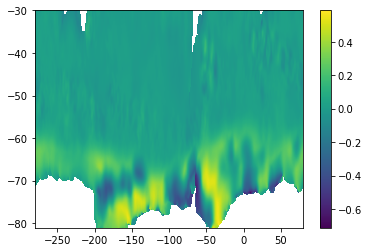

In [13]:
pcolormesh(lon,lat,meanfiltered[0,:,:])
colorbar()

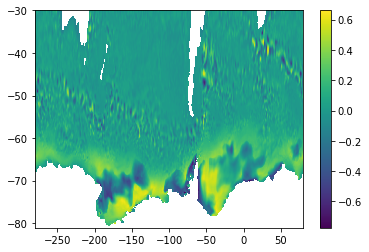

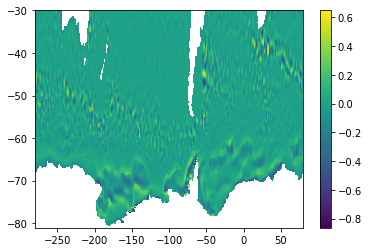

In [14]:
pcolormesh(lon,lat,sla[0,:,:])
colorbar()
show()
pcolormesh(lon,lat,sla[0,:,:]-meanfiltered[0,:,:])
colorbar()
show()

In [ ]:
slaa=xr.open_dataset(sla_file)
x0=-100
y0=-50
l=3

In [ ]:
import time

meanfiltered=zeros(shape(sla))
for tt in range(0,1):
    for ii in range(0,len(lon)):
        x0=lon[ii]
        start = time.time()
        print(x0)
        for jj in range(0,len(lat)):
            y0=lat[jj]
            if np.ma.is_masked(sla[tt,jj,ii])!=True:
                mfield=slaa.eta_t[tt ,:,:].sel(xt_ocean_sub01=slice(x0-l, x0+l))\
                   .sel(yt_ocean_sub01=slice(y0-l,y0+l)).mean()
                meanfiltered[tt,jj,ii]=mfield.values
                #print(mfield.values)
            else:
                meanfiltered[tt,jj,ii]=np.nan
        end = time.time()
        print(end - start)

-279.95
7.223602533340454
-279.84999999999997
7.139313459396362
-279.74999999999994
7.1955273151397705
-279.6499999999999
7.1494691371917725
-279.5499999999999
7.03558874130249
-279.4499999999999
6.929921388626099
-279.34999999999985
6.971993446350098
-279.24999999999983
7.220992565155029
-279.1499999999998
7.173485040664673
-279.0499999999998
7.274804353713989
-278.94999999999976
7.159639358520508
-278.84999999999974
7.11945366859436
-278.7499999999997
7.108598232269287
-278.6499999999997
7.11586332321167
-278.54999999999967
7.015029430389404
-278.44999999999965
7.30169939994812
-278.3499999999996
7.318745374679565
-278.2499999999996
7.313781976699829
-278.1499999999996
7.191051483154297
-278.04999999999956
7.300920009613037
-277.94999999999953
7.267291784286499
-277.8499999999995
7.126503229141235
-277.7499999999995
7.115683555603027
-277.64999999999947
7.332965850830078
-277.54999999999944
7.370922565460205
-277.4499999999994
7.275944709777832
-277.3499999999994
7.106759548187256
-2

7.120509624481201
-257.84999999999496
7.183994293212891
-257.74999999999494
7.10273814201355
-257.6499999999949
6.986854314804077
-257.5499999999949
7.182089805603027
-257.4499999999949
7.094845771789551
-257.34999999999485
6.987795829772949
-257.2499999999948
7.271680116653442
-257.1499999999948
7.138116359710693
-257.0499999999948
7.032792806625366
-256.94999999999476
7.0225510597229
-256.84999999999474
6.925201892852783
-256.7499999999947
7.026127815246582
-256.6499999999947
7.120609760284424
-256.54999999999467
7.167559623718262
-256.44999999999465
7.164714336395264
-256.3499999999946
6.946820974349976
-256.2499999999946
7.036060333251953
-256.1499999999946
6.9589433670043945
-256.04999999999455
7.040448188781738
-255.9499999999946
6.983216762542725
-255.84999999999457
6.909448146820068
-255.7499999999946
6.916459083557129
-255.64999999999458
6.82289457321167
-255.5499999999946
7.100336790084839
-255.4499999999946
6.982135534286499
-255.34999999999462
7.060208559036255
-255.2499999

In [ ]:
pcolormesh(lon,lat,sla[0,:,:]-meanfiltered[0,:,:])
colorbar()

In [ ]:
def plot_spectrum(im_fft):
    from matplotlib.colors import LogNorm
    # A logarithmic colormap
    plt.imshow(np.abs(im_fft), norm=LogNorm())
    plt.colorbar()

In [ ]:
from scipy import fftpack
fft = fftpack.fft2(sla[0,:,:])

plt.figure()
plot_spectrum(fft)
plt.title('Fourier transform')

In [ ]:
# In the lines following, we'll make a copy of the original spectrum and
# truncate coefficients.

# Define the fraction of coefficients (in each direction) we keep
keep_fraction = 0.02

# Call ff a copy of the original transform. Numpy arrays have a copy
# method for this purpose.
fft2 = fft.copy()

# Set r and c to be the number of rows and columns of the array.
r, c = fft2.shape

# Set to zero all rows with indices between r*keep_fraction and
# r*(1-keep_fraction):
fft2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0

# Similarly with the columns:
fft2[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0

plt.figure()
plot_spectrum(fft2)
plt.title('Filtered Spectrum')

In [ ]:
sla_new = fftpack.ifft2(fft2).real

In [ ]:
pcolormesh(lon,lat,sla_new)#,vmin=-100,vmax=100)
colorbar()

In [ ]:
from scipy import ndimage
blur = ndimage.gaussian_filter(sla,4)

In [ ]:
pcolormesh(lon,lat,blur[0,:,:])